# SELF-SUPERVISED DENOISING: PART TWO
### Authors: Claire Birnie and Sixiu Liu, KAUST

Author websites: 
- https://cebirnie92.github.io/ 
- https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))

## Tutorial Overview

On completion of this tutorial you will have learnt how to adapt your previously wrote blind-spot denoising procedure to handle noise that has some temporal relationship. In this instance, we imitate this using bandpassed noise. At the end of the tutorial, you will have the opportunity to denoise a field dataset often used for benchmarking random noise suppression procedures.

### Recap
As a reminder, the networks are trained in a self-supervised manner, i.e., the training data is the same as the inference data with no labels required! This tutorial is the second in the second in our self-supervised denoising series. For a recap on the methodology and the denoising performance under idealistic scenarios, review Tutorial One.

***

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Our unet functions just to speed things up
from unet import UNet
from tutorial_utils import regular_patching_2D, add_bandlimited_noise, weights_init, set_seed, make_data_loader,plot_corruption, plot_training_metrics, plot_synth_results, plot_field_results



In [2]:
cmap='RdBu'
vmin = -0.25
vmax = 0.25

set_seed(42) # For reproducibility set random, numpy and torch seeds

True

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the public data folder: https://exrcsdrive.kaust.edu.sa/exrcsdrive/index.php/s/vjjry6BZ3n3Ewei

with password: `kaust`

If the folder is no longer public, this is likely due to expired rights. Please email: cebirnie[at]kaust.edu.sa to request access.

This is the first dataset as was used in tutorial One therefore we can load it quickly without too much investigation as we already know its size and what it looks like (hence, why no 'TO DOs' this time!).

(196, 452)


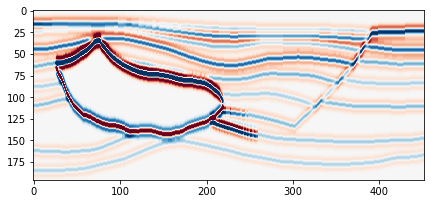

In [3]:
d = np.load("../data/Hess_PostStackSection.npy")

# Double-check the data dimensions
print(d.shape)

# Plot to see the noise free data
plt.figure(figsize=[7,5])
plt.imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)

### Add noise

As we can see from above, the data which you loaded in is the noise-free synthetic. This is great for helping us benchmark the results however we are really interested in testing the denoising performance of blind-spot networks there we need to add some noise that we wish to later suppress. Here we use a previously wrote function to add bandlimited noise to the dataset, this way it has some coherency along the time axis.

In [4]:
noisydata, _ = add_bandlimited_noise(d, sc=0.1)

#### Plot the noisy data to see what it looks like in comparison to the clean

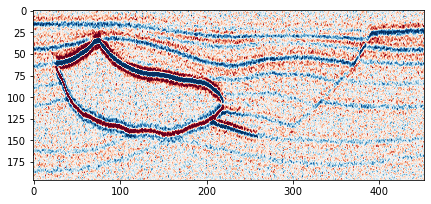

In [5]:
plt.figure(figsize=[7,5])
plt.imshow(noisydata, cmap=cmap, vmin=vmin, vmax=vmax)

### Patch data


At the moment we have a single image that we wish to denoise however to train the network we need to give it multiple data examples. Therefore, following common computer vision methodology, we will select random patches from the data for the networks training. 

Our patch implementation involves first regularly extracting patches from the image and then shuffling the patches such that they are in a random order. Later at the training stage these patches will be split into train and test dataset.

In [6]:
# Regularly extract patches from the noisy data
noisy_patches = regular_patching_2D(noisydata, 
                                    patchsize=[32, 32], # dimensions of extracted patch
                                    step=[4,6], # step to be taken in y,x for the extraction procedure
                                   )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 2870 patches


#### Visualise the training patches

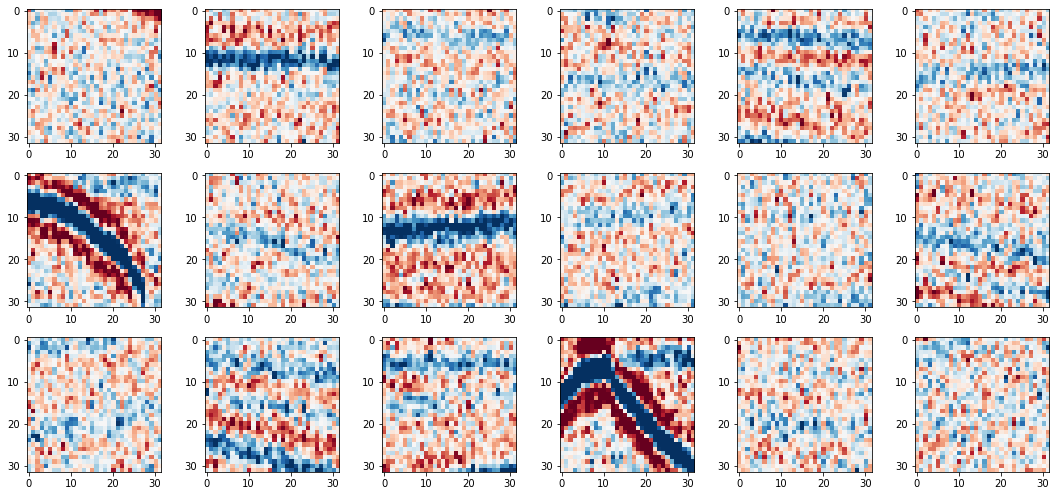

In [7]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

***

# Step Two - Blindspot corruption of training data

As we already wrote this in Tutorial One then we shall not write it again here. If you wrote it slightly different in Tutorial One then copy-paste it into this notebook.

As a reminder:

>Now we have made our noisy data into patches such that we have an adequate number to train the network, we now need to pre-process these noisy patches prior to being input into the network. 
>
>Our implementation of the preprocessing involves:
>
>   - selecting the active pixels 
>   - selecting the neighbourhood pixel for each active pixel, which it will take the value of
>   - replacing each active pixels' value with its neighbourhood pixels' value
>   - creating a active pixel 'mask' which shows the location of the active pixels on the patch
>    
>The first three steps are important for the pre-processing of the noisy patches, whilst the fourth step is required for identifying the locations on which to compute the loss function during training.

In [8]:
def multi_active_pixels(patch, 
                        num_activepixels, 
                        neighbourhood_radius=5,
                       ):
    """ Function to identify multiple active pixels and replace with values from neighbouring pixels
    
    Parameters
    ----------
    patch : numpy 2D array
        Noisy patch of data to be processed
    num_activepixels : int
        Number of active pixels to be selected within the patch
    neighbourhood_radius : int
        Radius over which to select neighbouring pixels for active pixel value replacement
    Returns
    -------
        cp_ptch : numpy 2D array
            Processed patch 
        mask : numpy 2D array
            Mask showing location of active pixels within the patch 
    """

    n_rad = neighbourhood_radius  # descriptive variable name was a little long

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP ONE: SELECT ACTIVE PIXEL LOCATIONS
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)
    id_aps = (idx_aps, idy_aps)
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP TWO: SELECT NEIGHBOURING PIXEL LOCATIONS
    
    # PART 1: Compute Shift
    # For each active pixel compute shift for finding neighbouring pixel and find pixel
    x_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    y_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    
    # OPTIONAL: don't allow replacement with itself
    for i in range(len(x_neigh_shft)):
        if x_neigh_shft[i] == 0 and y_neigh_shft[i] == 0:
            # This means its replacing itself with itself...
            shft_options = np.trim_zeros(np.arange(-n_rad // 2 + 1, n_rad // 2 + 1))
            x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)

    # PART 2: Find x and y locations of neighbours for the replacement
    idx_neigh = idx_aps + x_neigh_shft
    idy_neigh = idy_aps + y_neigh_shft    
    # Ensuring neighbouring pixels within patch window
    idx_neigh = idx_neigh + (idx_neigh < 0) * patch.shape[0] - (idx_neigh >= patch.shape[0]) * patch.shape[0]
    idy_neigh = idy_neigh + (idy_neigh < 0) * patch.shape[1] - (idy_neigh >= patch.shape[1]) * patch.shape[1]
    # Get x,y of neighbouring pixels
    id_neigh = (idx_neigh, idy_neigh)
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP THREE: REPLACE ACTIVE PIXEL VALUES BY NEIGHBOURS
    cp_ptch = patch.copy()
    cp_ptch[id_aps] = patch[id_neigh]
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP FOUR: MAKE ACTIVE PIXEL MASK
    # Make mask and corrupted patch
    mask = np.ones_like(patch)
    mask[id_aps] = 0.

    return cp_ptch, mask


We are confident this function works as we wrote and checked it in the previous tutorial. 

#### TO DO: SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE) AND NEIGHBOURHOOD RADIUS

For the WGN suppression, the percent of active pixels chosen in literature ranges from 0.5 and 2%. However, in this tutorial our noise has some temporal dependency as it is bandlimited. Therefore, Birnie et al., 2021, use a significantly higher percent of active pixels: 25%. This is the equivalent to replacing every fourth pixel value. Randomising the noise but also interupting the consistency of the signal.

With respect to the neighbourhood radius, increasing this also helps to add more randomnicity into the corrupted data patches. The value in tutorial one was 5.

In [9]:
# Choose the percent of active pixels per patch
perc_active = 25
# Choose the neighbourhood_radius to be searched for the neighbouring pixel
neighbourhood_radius = 15


Number of active pixels selected: 
 25.00 percent equals 256 pixels


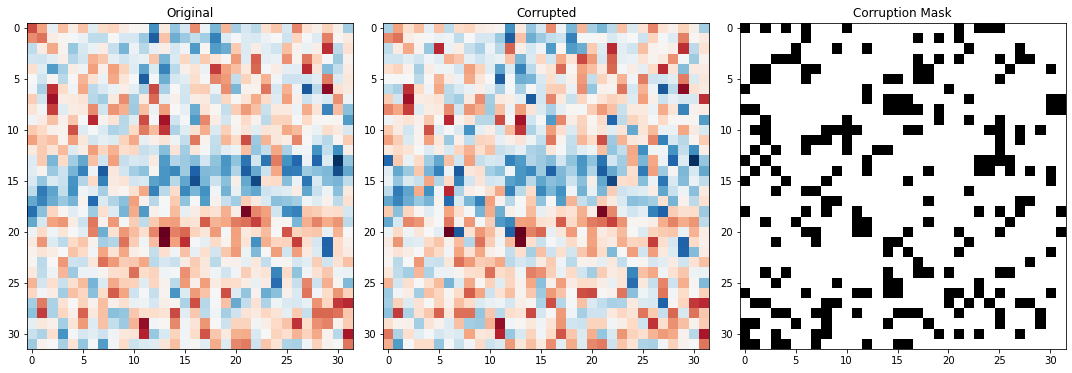

In [10]:
# Compute the total number of pixels within a patch
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
# Compute the number that should be active pixels based on the choosen percentage
num_activepixels = int(np.floor((total_num_pixels/100) * perc_active))
print("Number of active pixels selected: \n %.2f percent equals %i pixels"%(perc_active,num_activepixels))

# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[5], 
                                       num_activepixels=num_activepixels, 
                                       neighbourhood_radius=neighbourhood_radius, 
                                      )

# Visulise the coverage of active pixels within a patch
fig,axs = plot_corruption(noisy_patches[5], crpt_patch, mask)

***

# Step three - Set up network

As in Tutorial One, we will use a standard UNet architecture. As the architecture is independent to the blind-spot denoising procedure presented, it will be created via functions as opposed to being wrote within the notebook. 

In [11]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA Tesla V100-SXM2-32GB


#### Build the network

In [12]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(weights_init) 

/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/Solutions/tutorial_utils.py:267: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/Solutions/tutorial_utils.py:268: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


#### TO DO: SELECT THE NETWORKS TRAINING PARAMETERS

In [13]:
lr = 0.0001  # Learning rate
criterion = nn.L1Loss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

***

# Step four - training

Now we have successfully built our network and prepared our data - by patching it to get adequate training samples and creating the input data by selecting and corrupting the active pixels. We are now ready to train the network. Remember, the network training is slightly different to standard image processing tasks in that we will only be computing the loss on the active pixels.

As we already wrote the N2V train and validation functions and the training for loop in Tutorial One, we won't rewrite them here. If you wrote it slightly differently than us, please copy-paste your functions into the relevant cells.

#### TO DO: DEFINE TRAINING PARAMETERS
The longer the network is exposed to the data the better chance it has at learning the signal however it also gets a better chance at learning to recreate the noise. Remember this is in essence, unsupervised learning and the networks target is the original noisy data. Therefore, training for a large number of epochs may be non-optimal.

In [14]:
# Choose the number of epochs
n_epochs = 25  

# Choose number of training and validation samples
n_training = 2048
n_test = 256

# Choose the batch size for the networks training
batch_size = 128

In [15]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

In [16]:
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    """ Blind-spot network training function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where training will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Training loss across full dataset (i.e., all batches)
        accuracy : float
            Training RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        
        optimizer.zero_grad()
        
        # Predict the denoised image based on current network weights
        yprob = model(X)

        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        # TO DO: Compute loss function only at masked locations and backpropogate it
        # (Hint: only two lines required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        ls.backward()        
        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
            
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

In [17]:
def n2v_evaluate(model,
                 criterion, 
                 optimizer, 
                 data_loader, 
                 device):
    """ Blind-spot network evaluation function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where network computation will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Validation loss across full dataset (i.e., all batches)
        accuracy : float
            Validation RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        optimizer.zero_grad()
        
        yprob = model(X)

        with torch.no_grad():            
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
            # TO DO: Compute loss function only at masked locations 
            # (Hint: only one line required)
            ls = criterion(yprob * (1 - mask), y * (1 - mask))
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

In [18]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        
        # TO DO: USE ACTIVE PIXEL FUNCTION TO COMPUTE INPUT DATA AND MASKS
        # Hint: One line of code
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=neighbourhood_radius, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    # TO DO: Incorporate previously wrote n2v_train function
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    # TO DO: Incorporate previously wrote n2v_evaluate function
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|██████████| 2/2 [00:00<00:00, 22.09it/s]


Epoch 0, 
    Training Loss 0.0177,     Training Accuracy 0.1115, 
    Test Loss 0.0155,     Test Accuracy 0.0931 


100%|██████████| 2/2 [00:00<00:00, 23.04it/s]


Epoch 1, 
    Training Loss 0.0145,     Training Accuracy 0.0864, 
    Test Loss 0.0139,     Test Accuracy 0.0841 


100%|██████████| 2/2 [00:00<00:00, 22.07it/s]


Epoch 2, 
    Training Loss 0.0137,     Training Accuracy 0.0818, 
    Test Loss 0.0133,     Test Accuracy 0.0799 


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]


Epoch 3, 
    Training Loss 0.0132,     Training Accuracy 0.0788, 
    Test Loss 0.0130,     Test Accuracy 0.0784 


100%|██████████| 2/2 [00:00<00:00, 22.56it/s]


Epoch 4, 
    Training Loss 0.0129,     Training Accuracy 0.0777, 
    Test Loss 0.0128,     Test Accuracy 0.0776 


100%|██████████| 2/2 [00:00<00:00, 22.41it/s]


Epoch 5, 
    Training Loss 0.0127,     Training Accuracy 0.0774, 
    Test Loss 0.0126,     Test Accuracy 0.0775 


100%|██████████| 2/2 [00:00<00:00, 22.20it/s]


Epoch 6, 
    Training Loss 0.0126,     Training Accuracy 0.0772, 
    Test Loss 0.0126,     Test Accuracy 0.0775 


100%|██████████| 2/2 [00:00<00:00, 22.60it/s]


Epoch 7, 
    Training Loss 0.0125,     Training Accuracy 0.0771, 
    Test Loss 0.0124,     Test Accuracy 0.0773 


100%|██████████| 2/2 [00:00<00:00, 22.62it/s]


Epoch 8, 
    Training Loss 0.0124,     Training Accuracy 0.0768, 
    Test Loss 0.0124,     Test Accuracy 0.0773 


100%|██████████| 2/2 [00:00<00:00, 22.09it/s]


Epoch 9, 
    Training Loss 0.0123,     Training Accuracy 0.0766, 
    Test Loss 0.0123,     Test Accuracy 0.0770 


100%|██████████| 2/2 [00:00<00:00, 22.67it/s]


Epoch 10, 
    Training Loss 0.0123,     Training Accuracy 0.0767, 
    Test Loss 0.0123,     Test Accuracy 0.0772 


100%|██████████| 2/2 [00:00<00:00, 22.60it/s]


Epoch 11, 
    Training Loss 0.0122,     Training Accuracy 0.0763, 
    Test Loss 0.0123,     Test Accuracy 0.0769 


100%|██████████| 2/2 [00:00<00:00, 22.57it/s]


Epoch 12, 
    Training Loss 0.0122,     Training Accuracy 0.0762, 
    Test Loss 0.0122,     Test Accuracy 0.0763 


100%|██████████| 2/2 [00:00<00:00, 22.59it/s]


Epoch 13, 
    Training Loss 0.0122,     Training Accuracy 0.0759, 
    Test Loss 0.0121,     Test Accuracy 0.0762 


100%|██████████| 2/2 [00:00<00:00, 22.58it/s]


Epoch 14, 
    Training Loss 0.0121,     Training Accuracy 0.0755, 
    Test Loss 0.0121,     Test Accuracy 0.0756 


100%|██████████| 2/2 [00:00<00:00, 23.59it/s]


Epoch 15, 
    Training Loss 0.0121,     Training Accuracy 0.0749, 
    Test Loss 0.0121,     Test Accuracy 0.0751 


100%|██████████| 2/2 [00:00<00:00, 22.57it/s]


Epoch 16, 
    Training Loss 0.0121,     Training Accuracy 0.0748, 
    Test Loss 0.0121,     Test Accuracy 0.0748 


100%|██████████| 2/2 [00:00<00:00, 22.02it/s]


Epoch 17, 
    Training Loss 0.0120,     Training Accuracy 0.0741, 
    Test Loss 0.0121,     Test Accuracy 0.0744 


100%|██████████| 2/2 [00:00<00:00, 22.56it/s]


Epoch 18, 
    Training Loss 0.0119,     Training Accuracy 0.0737, 
    Test Loss 0.0120,     Test Accuracy 0.0739 


100%|██████████| 2/2 [00:00<00:00, 22.55it/s]


Epoch 19, 
    Training Loss 0.0119,     Training Accuracy 0.0735, 
    Test Loss 0.0119,     Test Accuracy 0.0735 


100%|██████████| 2/2 [00:00<00:00, 22.43it/s]


Epoch 20, 
    Training Loss 0.0119,     Training Accuracy 0.0731, 
    Test Loss 0.0119,     Test Accuracy 0.0730 


100%|██████████| 2/2 [00:00<00:00, 22.55it/s]


Epoch 21, 
    Training Loss 0.0119,     Training Accuracy 0.0728, 
    Test Loss 0.0119,     Test Accuracy 0.0733 


100%|██████████| 2/2 [00:00<00:00, 23.48it/s]


Epoch 22, 
    Training Loss 0.0118,     Training Accuracy 0.0725, 
    Test Loss 0.0118,     Test Accuracy 0.0720 


100%|██████████| 2/2 [00:00<00:00, 22.60it/s]


Epoch 23, 
    Training Loss 0.0118,     Training Accuracy 0.0720, 
    Test Loss 0.0117,     Test Accuracy 0.0721 


100%|██████████| 2/2 [00:00<00:00, 22.35it/s]

Epoch 24, 
    Training Loss 0.0118,     Training Accuracy 0.0718, 
    Test Loss 0.0119,     Test Accuracy 0.0718 


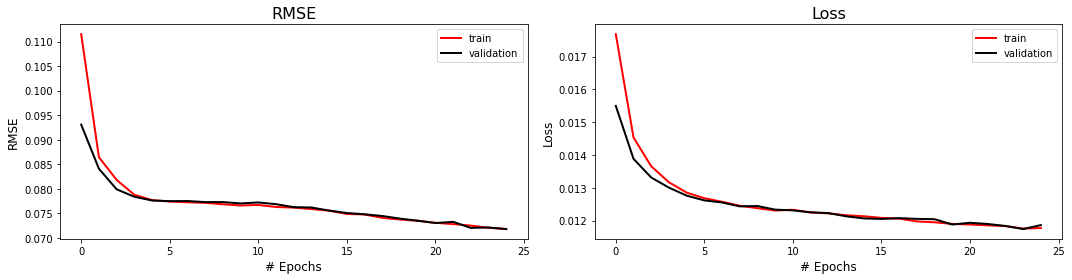

In [19]:
# Plotting trainnig metrics using pre-made function
fig,axs = plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

***

## Step five - Apply trained model

The model is now trained and ready for its denoising capabilities to be tested. 

For the standard network application, the noisy image does not require any data patching nor does it require the active pixel pre-processing required in training. In other words, the noisy image can be fed directly into the network for denoising.

#### TO DO: DENOISE NEW NOISY DATASET

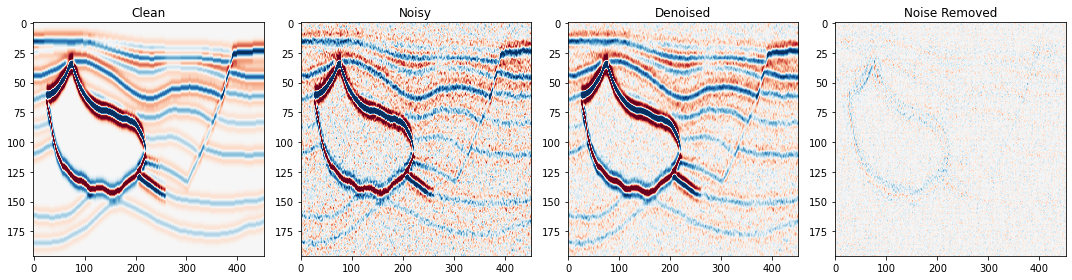

In [20]:
# Make a new noisy realisation so it's different from the training set but with roughly same level of noise
testdata, _ = add_bandlimited_noise(d, sc=0.1)

# Convert dataset in tensor for prediction purposes
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()

# Run test dataset through network
network.eval()
test_prediction = network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig,axs = plot_synth_results(d, testdata, test_pred)

***

# PART TWO : APPLYING TO FIELD DATA

(696, 300)


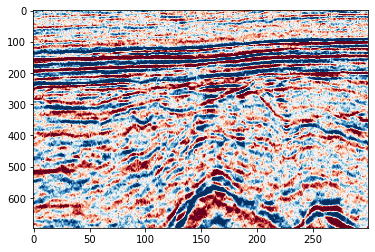

In [21]:
field_data = np.load("../data/FieldExample_RandomNoise.npy")[:696,:300]
print(field_data.shape)
# Plot to see the noise free data
plt.imshow(field_data, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

#### Patch the data and visualise

As with all our previous examples, this is only a 2D seismic section therefore we need to patch it to generate adequate training samples.

In [22]:
# Regularly extract patches from the noisy data
noisy_patches = regular_patching_2D(field_data, 
                                    patchsize=[32, 32], # dimensions of extracted patch
                                    step=[4,6], # step to be taken in y,x for the extraction procedure
                                   )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 7470 patches


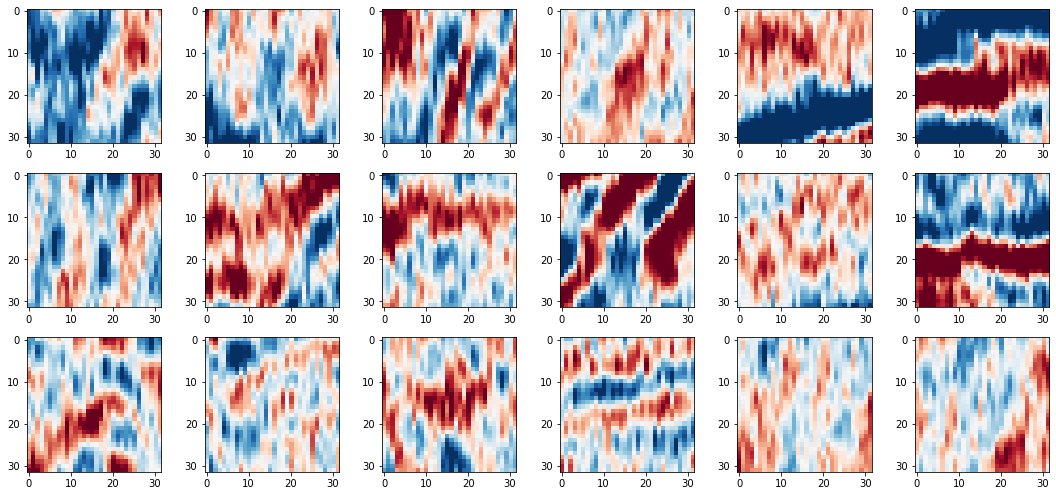

In [23]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

#### TO DO: SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE) AND NEIGHBOURHOOD RADIUS

In [24]:
# Choose the percent of active pixels per patch
perc_active = 33
# Choose the neighbourhood_radius to be searched for the neighbouring pixel
neighbourhood_radius = 15


Number of active pixels selected: 
 33.00 percent equals 337 pixels


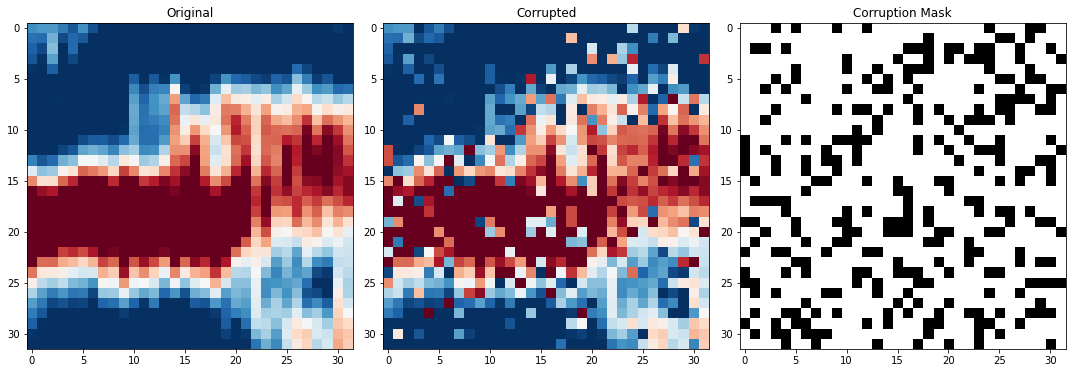

In [25]:
# Compute the total number of pixels within a patch
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
# Compute the number that should be active pixels based on the choosen percentage
num_activepixels = int(np.floor((total_num_pixels/100) * perc_active))
print("Number of active pixels selected: \n %.2f percent equals %i pixels"%(perc_active,num_activepixels))

# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[5], 
                                       num_activepixels=num_activepixels, 
                                       neighbourhood_radius=neighbourhood_radius, 
                                      )

# Visulise the coverage of active pixels within a patch
fig,axs = plot_corruption(noisy_patches[5], crpt_patch, mask)

***

## Step Three - Set up network

#### TO DO: MAKE NETWORK FOR FIELD DATA

In [26]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(weights_init) 

/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/Solutions/tutorial_utils.py:267: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/Solutions/tutorial_utils.py:268: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


#### TO DO: SELECT THE NETWORKS TRAINING PARAMETERS

In [27]:
lr = 0.0001  # Learning rate
criterion = nn.L1Loss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

***

# Step Four - training

As we have the functions already above then we only need to repeat the defining of the training parameters and the training for loop.

#### TO DO: DEFINE TRAINING PARAMETERS


In [28]:
# Choose the number of epochs
n_epochs = 15  

# Choose number of training and validation samples
n_training = 2048
n_test = 256

# Choose the batch size for the networks training
batch_size = 128

In [29]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

In [30]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):        
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=neighbourhood_radius, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = 128,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|██████████| 2/2 [00:00<00:00, 22.18it/s]


Epoch 0, 
    Training Loss 0.0282,     Training Accuracy 0.1342, 
    Test Loss 0.0202,     Test Accuracy 0.0944 


100%|██████████| 2/2 [00:00<00:00, 22.57it/s]


Epoch 1, 
    Training Loss 0.0179,     Training Accuracy 0.0861, 
    Test Loss 0.0160,     Test Accuracy 0.0773 


100%|██████████| 2/2 [00:00<00:00, 22.62it/s]


Epoch 2, 
    Training Loss 0.0151,     Training Accuracy 0.0739, 
    Test Loss 0.0144,     Test Accuracy 0.0710 


100%|██████████| 2/2 [00:00<00:00, 22.88it/s]


Epoch 3, 
    Training Loss 0.0140,     Training Accuracy 0.0692, 
    Test Loss 0.0138,     Test Accuracy 0.0687 


100%|██████████| 2/2 [00:00<00:00, 22.54it/s]


Epoch 4, 
    Training Loss 0.0135,     Training Accuracy 0.0674, 
    Test Loss 0.0134,     Test Accuracy 0.0669 


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 5, 
    Training Loss 0.0130,     Training Accuracy 0.0655, 
    Test Loss 0.0131,     Test Accuracy 0.0653 


100%|██████████| 2/2 [00:00<00:00, 22.69it/s]


Epoch 6, 
    Training Loss 0.0128,     Training Accuracy 0.0642, 
    Test Loss 0.0128,     Test Accuracy 0.0645 


100%|██████████| 2/2 [00:00<00:00, 22.60it/s]


Epoch 7, 
    Training Loss 0.0128,     Training Accuracy 0.0643, 
    Test Loss 0.0130,     Test Accuracy 0.0655 


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 8, 
    Training Loss 0.0125,     Training Accuracy 0.0635, 
    Test Loss 0.0125,     Test Accuracy 0.0636 


100%|██████████| 2/2 [00:00<00:00, 22.61it/s]


Epoch 9, 
    Training Loss 0.0124,     Training Accuracy 0.0629, 
    Test Loss 0.0125,     Test Accuracy 0.0636 


100%|██████████| 2/2 [00:00<00:00, 23.02it/s]


Epoch 10, 
    Training Loss 0.0122,     Training Accuracy 0.0621, 
    Test Loss 0.0123,     Test Accuracy 0.0625 


100%|██████████| 2/2 [00:00<00:00, 22.65it/s]


Epoch 11, 
    Training Loss 0.0121,     Training Accuracy 0.0616, 
    Test Loss 0.0122,     Test Accuracy 0.0619 


100%|██████████| 2/2 [00:00<00:00, 23.61it/s]


Epoch 12, 
    Training Loss 0.0120,     Training Accuracy 0.0611, 
    Test Loss 0.0125,     Test Accuracy 0.0629 


100%|██████████| 2/2 [00:00<00:00, 22.29it/s]


Epoch 13, 
    Training Loss 0.0120,     Training Accuracy 0.0609, 
    Test Loss 0.0120,     Test Accuracy 0.0610 


100%|██████████| 2/2 [00:00<00:00, 22.63it/s]

Epoch 14, 
    Training Loss 0.0118,     Training Accuracy 0.0599, 
    Test Loss 0.0119,     Test Accuracy 0.0601 


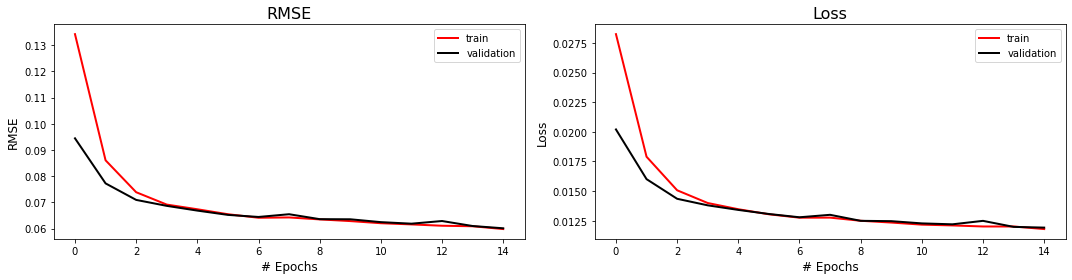

In [31]:
# Plotting trainnig metrics using pre-made function
fig,axs = plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

## Step five - Apply trained model

The model is now trained and ready for its denoising capabilities to be tested. 

For the standard network application, the noisy image does not require any data patching nor does it require the active pixel pre-processing required in training. In other words, the noisy image can be fed directly into the network for denoising.

#### TO DO: APPLY THE NETWORK TO THE ORIGINAL NOISY DATA

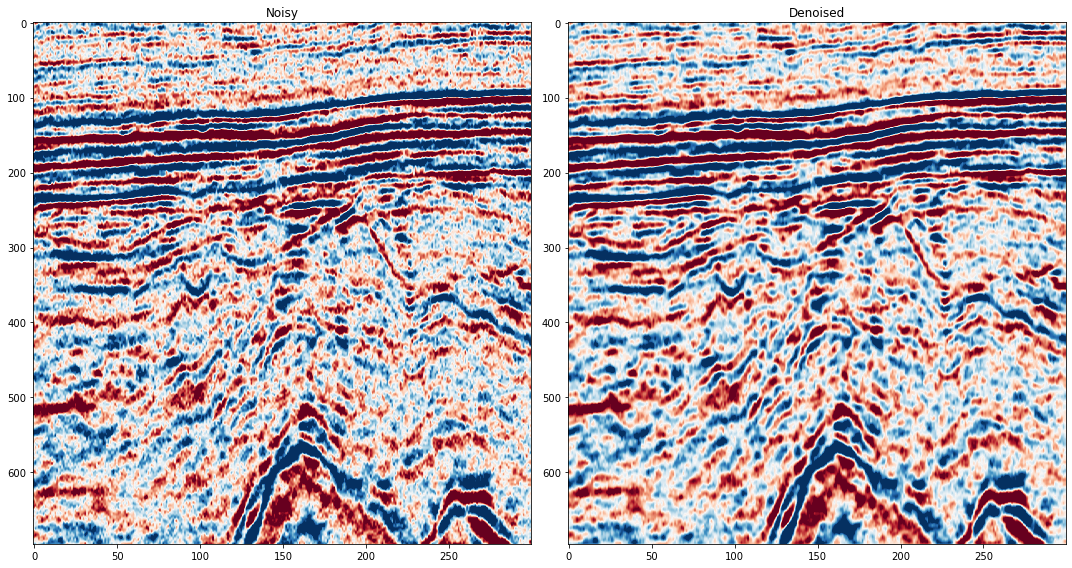

In [32]:
# Convert field dataset to tensor for prediction purposes
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(field_data,axis=0),axis=0)).float()

# Run test dataset through network
network.eval()
test_prediction = network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig,axs = plot_field_results(field_data, test_pred)